# Import Packages

In [1]:
import numpy as np
import torch
import torch.nn as nn
from torch.optim import Optimizer
from torch.func import vmap
from torch.autograd import Variable
import random
from tqdm import tqdm
import math
import matplotlib.pyplot as plt
from matplotlib_inline.backend_inline import set_matplotlib_formats

In [2]:
%cd pinnsformer_forked

/home/leiweimu/pinnsformer_forked


In [3]:
from util import *
from model.pinn import PINNs
from model.pinnsformer import PINNsformer

# SketchySGD

In [4]:
class SketchySGD(Optimizer):
    """Implements SketchySGD. We assume that there is only one parameter group to optimize.
    Args:
        params (iterable): iterable of parameters to optimize or dicts defining
            parameter groups
        rank (int): sketch rank
        rho (float): regularization
        lr (float): learning rate
        weight_decay (float): weight decay parameter
        hes_update_freq (int): how frequently we should update the Hessian approximation
        momentum (float): momentum parameter
        proportional (bool): option to maintain lr to rho ratio, even when lr decays
        chunk_size (int): number of Hessian-vector products to compute in parallel
                          if set to None, binary search will be used to find the maximally allowed value
    """
    def __init__(self, params, rank = 100, rho = 0.1, lr = 0.01, weight_decay = 0.0,
                 hes_update_freq = 100, momentum = 0.0, proportional = False, 
                 chunk_size = None, line_search_fn = None, verbose = False):
        # initialize the optimizer    
        defaults = dict(rank = rank, rho = rho, lr = lr, weight_decay = weight_decay, 
                        hes_update_freq = hes_update_freq, proportional = proportional,
                        chunk_size = chunk_size, momentum = momentum, line_search_fn = line_search_fn)
        self.rank = rank
        self.hes_update_freq = hes_update_freq
        self.proportional = proportional
        self.chunk_size = chunk_size
        self.ratio = rho / lr
        self.hes_iter = 0
        self.U = None
        self.S = None
        self.counter = 0
        self.momentum = momentum
        self.momentum_buffer = None
        self.line_search_fn = line_search_fn
        self.large_step_size_index = []
        self.verbose = verbose
        super(SketchySGD, self).__init__(params, defaults)
    
    def step(self, closure = None):
        loss = None
        grad_tuple = None
        if closure is not None:
            with torch.enable_grad():
                loss, grad_tuple = closure()

        # update Hessian approximation, if needed
        g = torch.cat([gradient.view(-1) for gradient in grad_tuple if gradient is not None])
        if self.hes_iter % self.hes_update_freq == 0:
            params = []

            for group in self.param_groups:
                for p in group['params']:
                    params.append(p)

            # update preconditioner
            self._update_preconditioner(params, g)

        g = g.detach()

        # update momentum buffer
        if self.momentum_buffer is None: 
            self.momentum_buffer = g
        else:
            self.momentum_buffer = self.momentum * self.momentum_buffer + g

        # one step update
        for group_idx, group in enumerate(self.param_groups):
            lr = group['lr']
            weight_decay = group['weight_decay']

            # Adjust rho to be proportional to lr, if necessary
            if self.proportional:
                rho = lr * self.ratio
            else:
                rho = group['rho']

            # compute gradient as a long vector
            # g = torch.cat([p.grad.view(-1) for p in group['params'] if p.grad is not None]) # only get gradients if they exist!
            # calculate the search direction by Nystrom sketch and solve
            UTg = torch.mv(self.U.t(), self.momentum_buffer) 
            g_new = torch.mv(self.U, (self.S + rho).reciprocal() * UTg) + self.momentum_buffer / rho - torch.mv(self.U, UTg) / rho
            
            # use backtracking line search to find an appropriate step-size
            step_size = lr
            direction = g_new.detach().neg()
            if self.line_search_fn is not None: 
                # possibly reduce the initial step size for the very first iteration
                if self.hes_iter == 0: 
                    step_size = min(1., 1. / g.abs().sum()) * lr
                # get a copy of current param values (as evaluating loss requires overwriting current param)
                current_params = self._clone_param(group_idx)
                # compute the dot product of gradient
                grad_dir_prod = g.dot(direction).item()
                # define the objective/loss evaluation function
                def obj_func(current_params, step_size, direction): 
                    # set new param values
                    self._add_grad(group_idx, step_size, direction)
                    # obtain objective/loss
                    obj_value, grad = closure()
                    flat_grad = torch.cat([gradient.view(-1) for gradient in grad if gradient is not None]).detach()
                    # revert back to the original/current param values
                    self._set_param(group_idx, current_params)

                    # return obj_value
                    return float(obj_value), flat_grad
                # search for the sufficient decrease step-size
                if self.line_search_fn == "backtracking": 
                    step_size = self._backtracking(obj_func, current_params, step_size, direction, loss.item(), grad_dir_prod, use_interpolation=True)
                elif self.line_search_fn == "strong_wolfe": 
                    step_size = self._strong_wolfe(obj_func, current_params, step_size, direction, loss.item(), g, grad_dir_prod)
                else: 
                    raise Exception(f'Line search function \"{self.line_search_fn}\" is not supported.')
            # store step-size in state dict
            self.state[group_idx]['step_size'] = step_size
            # update model parameters with either fixed or found step-size
            self._add_grad(group_idx, step_size, direction)
        
        self.hes_iter += 1

        return loss
    
    def _update_preconditioner(self, params, gradsH):
        p = gradsH.shape[0]
        # Generate test matrix (NOTE: This is transposed test matrix)
        Phi = (torch.randn(self.rank, p) / (p ** 0.5)).to(params[0].device)
        
        if self.chunk_size is None: 
            self._set_chunk_size(params, gradsH, Phi)

        # Calculate sketch (NOTE: This is transposed sketch)
        Y = self._hvp_vmap(gradsH, params)(Phi)

        # Calculate shift
        shift = torch.finfo(Y.dtype).eps * 10
        Y_shifted = Y + shift * Phi
        # Calculate Phi^T * H * Phi (w/ shift) for Cholesky
        choleskytarget = torch.mm(Y_shifted, Phi.t())
        # Perform Cholesky, if fails, do eigendecomposition
        # The new shift is the abs of smallest eigenvalue (negative) plus the original shift
        try:
            C = torch.linalg.cholesky(choleskytarget)
        except:
            # eigendecomposition, eigenvalues and eigenvector matrix
            eigs, eigvectors = torch.linalg.eigh(choleskytarget)
            shift = shift + torch.abs(torch.min(eigs))
            # add shift to eigenvalues
            eigs = eigs + shift
            # print(eigs)
            # put back the matrix for Cholesky by eigenvector * eigenvalues after shift * eigenvector^T 
            C = torch.linalg.cholesky(torch.mm(eigvectors, torch.mm(torch.diag(eigs), eigvectors.T)))

        try: 
            B = torch.linalg.solve_triangular(C, Y_shifted, upper = False, left = True)
        # temporary fix for issue @ https://github.com/pytorch/pytorch/issues/97211
        except: 
            B = torch.linalg.solve_triangular(C.to('cpu'), Y_shifted.to('cpu'), upper = False, left = True).to(C.device)
        _, S, UT = torch.linalg.svd(B, full_matrices = False) # B = V * S * U^T b/c we have been using transposed sketch
        self.U = UT.t()
        self.S = torch.max(torch.square(S) - shift, torch.tensor(0.0))
        
        if self.verbose: 
            # print low-rank Hessian approximation (without rho)
            print(f'Hessian Approximation: {torch.mm(torch.mm(self.U, torch.diag(self.S)), self.U.t())}')

    def _hvp_vmap(self, grad_params, params):
        return vmap(lambda v: hvp(grad_params, params, v), in_dims = 0, chunk_size=self.chunk_size)

    """
    Helper function for finding the maximally allowed chunck_size. 

    INPUT: 
    - params: ...
    - gradsH: ...
    - Phi: ...
    - safety_margin: float; free / total GPU memory ratio -- if the free memory is lower than the margin, 
                     then this suggests actual chunk size should be set at a multiplicative factor of the found value
    - safety_margin_factor: integer; multiplicative factor to use when the free memory is low
    """
    def _set_chunk_size(self, params, gradsH, Phi, safety_margin=0.05, safety_margin_factor=0.95): 
        # start with the rank
        self.chunk_size = self.rank
        # set bounds for the search
        max_size = self.rank
        min_size = 1
        while(True): 
            # update lower bound if attempted computation was successful
            try: 
                self._hvp_vmap(gradsH, params)(Phi)
                min_size = self.chunk_size
                # search range has converged to a single point
                if max_size - min_size <= 1: 
                    # grab memory information
                    free_mem, total_mem = torch.cuda.mem_get_info()
                    if free_mem / total_mem < safety_margin: 
                        min_size = int(safety_margin_factor * min_size)
                    # create some safety margin (e.g. 95% of the found size)
                    self.chunk_size = max(1, min_size)
                    torch.cuda.empty_cache()
                    break
            # update upper bound if attempted computation ran out of memory
            except RuntimeError as e:
                if str(e).startswith('CUDA out of memory.') and self.chunk_size > 1:
                    max_size = self.chunk_size
                    torch.cuda.empty_cache()
                # terminate if other runtime error occurred or chunk_size = 1 still ran out of memory
                else: 
                    raise e
            # halve the search range
            self.chunk_size = int(0.5 * (min_size + max_size))
        # report final chunk size
        print(f'SketchySGD: chunk size has been set to {self.chunk_size}.')

    """
    Helper function for performing the backtracking line search (Armijo rule).

    INPUT: 
    - current_params: Tensor; long flattened vector of the model parameters
    - step_size: Tensor (of size 1); initial step-size (learning rate) for the step
    - direction: Tensor; long flattened vector of the update direction
    - obj_value: Tensor (of size 1); objective value (loss) at the current value of the parameters
    - grad_dir_prod: Tensor (of size 1); result of the dot product of the gradient of the objective function and direction
    - c1: float; constant used in the evaluation of the sufficient decrease condition
    - alpha: float; constant multiplicative factor used to decrease step-size after each unsuccessful search
    - max_ls: integer; maximum number of line searches
    OUTPUT: 
    - step_size: Tensor; resulting step-size from the search
    """
    def _backtracking(self, obj_func, current_params, step_size, direction, obj_value, grad_dir_prod, c1=1e-4, alpha=0.5, max_ls=30, use_interpolation=True): 
        # compute objective function with the initial step-size
        obj_value_new = obj_func(current_params, step_size, direction)[0]
        # start line search
        ls_iter = 0
        while ls_iter < max_ls:
            # evaluate the sufficient decrease condition
            if obj_value_new > (obj_value + c1 * step_size * grad_dir_prod): 
                # find step size using quadratic interpolation
                if use_interpolation: 
                    step_size = self._quadratic_interpolate(obj_value, obj_value_new, grad_dir_prod, step_size)
                # decrease step-size by a constant multiplicative factor alpha
                else: 
                    step_size = alpha * step_size        
                # compute objective function with the new step-size
                obj_value_new = obj_func(current_params, step_size, direction)[0]
                ls_iter += 1
            # otherwise the condition is satisfied
            else: 
                break

        return step_size

    """
    Helper function for making a copy of the params in the given param group. 

    INPUT: 
    - group_idx: integer; index of the param group
    OUTPUT: 
    - step_size: list
    """
    def _clone_param(self, group_idx):
        return [p.clone(memory_format=torch.contiguous_format) for p in self.param_groups[group_idx]['params']]

    """
    Helper function for updating param values in the given param group.
    Specifically, x <- x + step_size * (update + weight_decay + x)
    Here we use the weight decay, and it is not the same as L2 regularization.

    INPUT: 
    - group_idx: integer; index of the param group
    - step_size: float; step-size
    - update: list; long Tensor representing the update direction
    """
    def _add_grad(self, group_idx, step_size, update):
        weight_decay = self.param_groups[group_idx]['weight_decay']
        offset = 0
        for p in self.param_groups[group_idx]['params']:
            numel = p.numel()
            p.data.add_(update[offset:offset + numel].view_as(p) + weight_decay * p.data, alpha=step_size)
            offset += numel

    """
    Helper function for assigning value to params in the given param group.
    Specifically, x <- params_data.

    INPUT: 
    - group_idx: integer; index of the param group
    - params_data: list; long Tensor representing the value to assign
    """
    def _set_param(self, group_idx, params_data):
        for p, pdata in zip(self.param_groups[group_idx]['params'], params_data):
            p.data.copy_(pdata)
    
        """
    Helper function for performing quadratic interpolation. 
    Specifically, compute x_hat_min = (-g1 * (x ** 2)) / (2 * (f2 - f1 - g1 * x)) > 0
    If x_hat_min < x_lower_bound, then x_new = x_lower_bound
    If x_lower_bound <= x_hat_min <= x_upper_bound, then x_new = x_hat_min
    If x_hat_min > x_upper_bound, then x_new = x_upper_bound

    INPUT: 
    - f1: float; function value at initial x, f(x_0)
    - f2: float; function value at current x, f(x)
    - g1: float; gradient at initial x, grad(f(x_0))
    - x: float; current x
    - bounds: tuple of floats; lower and upper bounds of the new x
    OUTPUT: 
    - x_new: float; value of the x in the bound that minimizes the interpolation
    """
    def _quadratic_interpolate(self, f1, f2, g1, x, bounds=None): 
        if bounds is not None:
            x_lower_bound, x_upper_bound = bounds
        else: 
            x_lower_bound = 0.5 * x
            x_upper_bound = 0.95 * x

        x_hat_min = (-g1 * (x ** 2)) / (2 * (f2 - f1 - g1 * x))

        return min(max(x_hat_min, x_lower_bound), x_upper_bound)
    
    def _cubic_interpolate(self, f1, f2, g1, g2, x1, x2, bounds=None): 
        if bounds is not None:
            xmin_bound, xmax_bound = bounds
        else:
            xmin_bound, xmax_bound = (x1, x2) if x1 <= x2 else (x2, x1)

        d1 = g1 + g2 - 3 * (f1 - f2) / (x1 - x2)
        d2_square = d1**2 - g1 * g2
            
        if d2_square >= 0:
            d2 = d2_square.sqrt()
            if x1 <= x2:
                min_pos = x2 - (x2 - x1) * ((g2 + d2 - d1) / (g2 - g1 + 2 * d2))
            else:
                min_pos = x1 - (x1 - x2) * ((g1 + d2 - d1) / (g1 - g2 + 2 * d2))
            return min(max(min_pos, xmin_bound), xmax_bound)
        else:
            return (xmin_bound + xmax_bound) / 2.

    def _strong_wolfe(self, obj_func, x, t, d, f, g, gtd, c1=1e-4, c2=0.9, tolerance_change=1e-9, max_ls=30): 
        d_norm = d.abs().max()
        g = g.clone(memory_format=torch.contiguous_format)
        f_new, g_new = obj_func(x, t, d)
        ls_func_evals = 1
        gtd_new = g_new.dot(d)
        
        if math.isinf(f_new) or math.isnan(f_new) or torch.isinf(gtd_new) or torch.isnan(gtd_new): 
            self.large_step_size_index.append(self.hes_iter)
            t = t / g.abs().sum()
            f_new, g_new = obj_func(x, t, d)
            gtd_new = g_new.dot(d)

        t_prev, f_prev, g_prev, gtd_prev = 0, f, g, gtd
        done = False
        ls_iter = 0
        while ls_iter < max_ls:
            if f_new > (f + c1 * t * gtd) or (ls_iter > 1 and f_new >= f_prev):
                bracket = [t_prev, t]
                bracket_f = [f_prev, f_new]
                bracket_g = [g_prev, g_new.clone(memory_format=torch.contiguous_format)]
                bracket_gtd = [gtd_prev, gtd_new]
                break

            if abs(gtd_new) <= -c2 * gtd:
                bracket = [t]
                bracket_f = [f_new]
                bracket_g = [g_new]
                done = True
                break

            if gtd_new >= 0:
                bracket = [t_prev, t]
                bracket_f = [f_prev, f_new]
                bracket_g = [g_prev, g_new.clone(memory_format=torch.contiguous_format)]
                bracket_gtd = [gtd_prev, gtd_new]
                break

            min_step = t + 0.01 * (t - t_prev)
            max_step = t * 10
            tmp = t
            t = self._cubic_interpolate(
                t_prev,
                f_prev,
                gtd_prev,
                t,
                f_new,
                gtd_new,
                bounds=(min_step, max_step))

            t_prev = tmp
            f_prev = f_new
            g_prev = g_new.clone(memory_format=torch.contiguous_format)
            gtd_prev = gtd_new
            f_new, g_new = obj_func(x, t, d)
            ls_func_evals += 1
            gtd_new = g_new.dot(d)
            ls_iter += 1

        if ls_iter == max_ls:
            bracket = [0, t]
            bracket_f = [f, f_new]
            bracket_g = [g, g_new]

        insuf_progress = False
        low_pos, high_pos = (0, 1) if bracket_f[0] <= bracket_f[-1] else (1, 0)
        while not done and ls_iter < max_ls:
            if abs(bracket[1] - bracket[0]) * d_norm < tolerance_change: break

            t = self._cubic_interpolate(bracket[0], bracket_f[0], bracket_gtd[0],
                               bracket[1], bracket_f[1], bracket_gtd[1])

            eps = 0.1 * (max(bracket) - min(bracket))
            if min(max(bracket) - t, t - min(bracket)) < eps:
                # interpolation close to boundary
                if insuf_progress or t >= max(bracket) or t <= min(bracket):
                    # evaluate at 0.1 away from boundary
                    if abs(t - max(bracket)) < abs(t - min(bracket)):
                        t = max(bracket) - eps
                    else:
                        t = min(bracket) + eps
                    insuf_progress = False
                else:
                    insuf_progress = True
            else:
                insuf_progress = False

            f_new, g_new = obj_func(x, t, d)
            ls_func_evals += 1
            gtd_new = g_new.dot(d)
            ls_iter += 1

            if f_new > (f + c1 * t * gtd) or f_new >= bracket_f[low_pos]:
                bracket[high_pos] = t
                bracket_f[high_pos] = f_new
                bracket_g[high_pos] = g_new.clone(memory_format=torch.contiguous_format)
                bracket_gtd[high_pos] = gtd_new
                low_pos, high_pos = (0, 1) if bracket_f[0] <= bracket_f[1] else (1, 0)
            else:
                if abs(gtd_new) <= -c2 * gtd:
                    done = True
                elif gtd_new * (bracket[high_pos] - bracket[low_pos]) >= 0:
                    # old high becomes new low
                    bracket[high_pos] = bracket[low_pos]
                    bracket_f[high_pos] = bracket_f[low_pos]
                    bracket_g[high_pos] = bracket_g[low_pos]
                    bracket_gtd[high_pos] = bracket_gtd[low_pos]

                # new point becomes new low
                bracket[low_pos] = t
                bracket_f[low_pos] = f_new
                bracket_g[low_pos] = g_new.clone(memory_format=torch.contiguous_format)
                bracket_gtd[low_pos] = gtd_new

        t = bracket[low_pos]
        f_new = bracket_f[low_pos]
        g_new = bracket_g[low_pos]
        
        return t

def hvp(grad_params, params, v):
    Hv = torch.autograd.grad(grad_params, params, grad_outputs = v,
                              retain_graph = True)
    Hv = tuple(Hvi.detach() for Hvi in Hv)
    return torch.cat([Hvi.reshape(-1) for Hvi in Hv])

def group_product(xs, ys):
    return sum([torch.sum(x * y) for (x, y) in zip(xs, ys)])

def normalize(v):
    s = torch.sqrt(group_product(v, v))
    v = [x / (s + 1e-6) for x in v]
    return v

# PyHessian

In [5]:
def group_product(xs, ys):
    """
    the inner product of two lists of variables xs,ys
    :param xs:
    :param ys:
    :return:
    """
    return sum([torch.sum(x * y) for (x, y) in zip(xs, ys)])


def group_add(params, update, alpha=1):
    """
    params = params + update*alpha
    :param params: list of variable
    :param update: list of data
    :return:
    """
    for i, p in enumerate(params):
        params[i].data.add_(update[i] * alpha)
    return params


def normalization(v):
    """
    normalization of a list of vectors
    return: normalized vectors v
    """
    s = group_product(v, v)
    s = s**0.5
    s = s.cpu().item()
    v = [vi / (s + 1e-6) for vi in v]
    return v


def get_params_grad(model):
    """
    get model parameters and corresponding gradients
    """
    params = []
    grads = []
    for param in model.parameters():
        if not param.requires_grad:
            continue
        params.append(param)
        grads.append(0. if param.grad is None else param.grad + 0.)
    return params, grads

def get_params(model):
    """
    get model parameters
    """
    params = []
    for param in model.parameters():
        if not param.requires_grad:
            continue
        params.append(param)
    return params

def hessian_vector_product(gradsH, params, v):
    """
    compute the hessian vector product of Hv, where
    gradsH is the gradient at the current point,
    params is the corresponding variables,
    v is the vector.
    """
    hv = torch.autograd.grad(gradsH,
                             params,
                             grad_outputs=v,
                             only_inputs=True,
                             retain_graph=True)
    return hv


def orthnormal(w, v_list):
    """
    make vector w orthogonal to each vector in v_list.
    afterwards, normalize the output w
    """
    for v in v_list:
        w = group_add(w, v, alpha=-group_product(w, v))
    return normalization(w)


class hessian():
    """
    The class used to compute :
        i) the top 1 (n) eigenvalue(s) of the neural network
        ii) the trace of the entire neural network
        iii) the estimated eigenvalue density
    """

    def __init__(self, model, criterion, data=None, dataloader=None, cuda=True, device='cuda'):
        """
        model: the model that needs Hessain information
        criterion: the loss function
        data: a single batch of data, including inputs and its corresponding labels
        dataloader: the data loader including bunch of batches of data
        """

        # make sure we either pass a single batch or a dataloader
        assert (data != None and dataloader == None) or (data == None and
                                                         dataloader != None)

        self.model = model.eval()  # make model is in evaluation model
        self.criterion = criterion

        if data != None:
            self.data = data
            self.full_dataset = False
        else:
            self.data = dataloader
            self.full_dataset = True

        if cuda:
            self.device = device
        else:
            self.device = 'cpu'

        # pre-processing for single batch case to simplify the computation.
        if not self.full_dataset:
            self.x, self.t = self.data
            x_res, x_left, x_right, x_upper, x_lower = self.x
            t_res, t_left, t_right, t_upper, t_lower = self.t
            
            if self.device != 'cpu':
                
                x_res, t_res = x_res.cuda(device=self.device), t_res.cuda(device=self.device)
                x_left, t_left = x_left.cuda(device=self.device), t_left.cuda(device=self.device)
                x_right, t_right = x_right.cuda(device=self.device), t_right.cuda(device=self.device)
                x_upper, t_upper = x_upper.cuda(device=self.device), t_upper.cuda(device=self.device)
                x_lower, t_lower = x_lower.cuda(device=self.device), t_lower.cuda(device=self.device)
                
                self.x = (x_res, x_left, x_right, x_upper, x_lower)
                self.t = (t_res, t_left, t_right, t_upper, t_lower)

            # if we only compute the Hessian information for a single batch data, we can re-use the gradients.
            outputs_res = self.model(x_res, t_res)
            outputs_left = self.model(x_left, t_left)
            outputs_right = self.model(x_right, t_right)
            outputs_upper = self.model(x_upper, t_upper)
            outputs_lower = self.model(x_lower, t_lower)
            
            outputs = (outputs_res, outputs_left, outputs_right, outputs_upper, outputs_lower) 
            
            loss = self.criterion(self.x, self.t, outputs)
            # loss.backward(create_graph=True)
            grad_tuple = torch.autograd.grad(loss, self.model.parameters(), create_graph=True)
            
        # this step is used to extract the parameters from the model
        
        # params, gradsH = get_params_grad(self.model)
        # self.params = params
        # self.gradsH = gradsH  # gradient used for Hessian computation
        self.params = get_params(self.model)
        self.gradsH = [gradient if gradient is not None else 0.0 for gradient in grad_tuple]

    def dataloader_hv_product(self, v):

        device = self.device
        num_data = 0  # count the number of datum points in the dataloader

        THv = [torch.zeros(p.size()).to(device) for p in self.params
              ]  # accumulate result
        for x, t in self.data:
            self.model.zero_grad()
            
            x_res, x_left, x_right, x_upper, x_lower = x
            t_res, t_left, t_right, t_upper, t_lower = t
            
            x_res, t_res = x_res.to(device), t_res.to(device)
            x_left, t_left = x_left.to(device), t_left.to(device)
            x_right, t_right = x_right.to(device), t_right.to(device)
            x_upper, t_upper = x_upper.to(device), t_upper.to(device)
            x_lower, t_lower = x_lower.to(device), t_lower.to(device)
            
            x = (x_res, x_left, x_right, x_upper, x_lower)
            t = (t_res, t_left, t_right, t_upper, t_lower)
            
            tmp_num_data = x_res.size(0)
            
            outputs_res = self.model(x_res, t_res)
            outputs_left = self.model(x_left, t_left)
            outputs_right = self.model(x_right, t_right)
            outputs_upper = self.model(x_upper, t_upper)
            outputs_lower = self.model(x_lower, t_lower)
            
            outputs = (outputs_res, outputs_left, outputs_right, outputs_upper, outputs_lower) 
            loss = self.criterion(x, t, outputs)
            # loss.backward(create_graph=True)
            grad_tuple = torch.autograd.grad(loss, self.model.parameters(), create_graph=True)
            # params, gradsH = get_params_grad(self.model)
            gradsH = [gradient if gradient is not None else 0.0 for gradient in grad_tuple]
            params = get_params(self.model)
            
            self.model.zero_grad()
            Hv = torch.autograd.grad(gradsH,
                                     params,
                                     grad_outputs=v,
                                     only_inputs=True,
                                     retain_graph=False)
            THv = [
                THv1 + Hv1 * float(tmp_num_data) + 0.
                for THv1, Hv1 in zip(THv, Hv)
            ]
            num_data += float(tmp_num_data)

        THv = [THv1 / float(num_data) for THv1 in THv]
        eigenvalue = group_product(THv, v).cpu().item()
        return eigenvalue, THv

    def eigenvalues(self, maxIter=100, tol=1e-3, top_n=1):
        """
        compute the top_n eigenvalues using power iteration method
        maxIter: maximum iterations used to compute each single eigenvalue
        tol: the relative tolerance between two consecutive eigenvalue computations from power iteration
        top_n: top top_n eigenvalues will be computed
        """

        assert top_n >= 1

        device = self.device

        eigenvalues = []
        eigenvectors = []

        computed_dim = 0

        while computed_dim < top_n:
            eigenvalue = None
            v = [torch.randn(p.size()).to(device) for p in self.params
                ]  # generate random vector
            v = normalization(v)  # normalize the vector

            for i in range(maxIter):
                v = orthnormal(v, eigenvectors)
                self.model.zero_grad()

                if self.full_dataset:
                    tmp_eigenvalue, Hv = self.dataloader_hv_product(v)
                else:
                    Hv = hessian_vector_product(self.gradsH, self.params, v)
                    tmp_eigenvalue = group_product(Hv, v).cpu().item()

                v = normalization(Hv)

                if eigenvalue == None:
                    eigenvalue = tmp_eigenvalue
                else:
                    if abs(eigenvalue - tmp_eigenvalue) / (abs(eigenvalue) +
                                                           1e-6) < tol:
                        break
                    else:
                        eigenvalue = tmp_eigenvalue
            eigenvalues.append(eigenvalue)
            eigenvectors.append(v)
            computed_dim += 1

        return eigenvalues, eigenvectors

    def trace(self, maxIter=100, tol=1e-3):
        """
        compute the trace of hessian using Hutchinson's method
        maxIter: maximum iterations used to compute trace
        tol: the relative tolerance
        """

        device = self.device
        trace_vhv = []
        trace = 0.

        for i in range(maxIter):
            self.model.zero_grad()
            v = [
                torch.randint_like(p, high=2, device=device)
                for p in self.params
            ]
            # generate Rademacher random variables
            for v_i in v:
                v_i[v_i == 0] = -1

            if self.full_dataset:
                _, Hv = self.dataloader_hv_product(v)
            else:
                Hv = hessian_vector_product(self.gradsH, self.params, v)
            trace_vhv.append(group_product(Hv, v).cpu().item())
            if abs(np.mean(trace_vhv) - trace) / (abs(trace) + 1e-6) < tol:
                return trace_vhv
            else:
                trace = np.mean(trace_vhv)

        return trace_vhv

    def density(self, iter=100, n_v=1):
        """
        compute estimated eigenvalue density using stochastic lanczos algorithm (SLQ)
        iter: number of iterations used to compute trace
        n_v: number of SLQ runs
        """

        device = self.device
        eigen_list_full = []
        weight_list_full = []

        for k in range(n_v):
            v = [
                torch.randint_like(p, high=2, device=device)
                for p in self.params
            ]
            # generate Rademacher random variables
            for v_i in v:
                v_i[v_i == 0] = -1
            v = normalization(v)

            # standard lanczos algorithm initlization
            v_list = [v]
            w_list = []
            alpha_list = []
            beta_list = []
            ############### Lanczos
            for i in range(iter):
                self.model.zero_grad()
                w_prime = [torch.zeros(p.size()).to(device) for p in self.params]
                if i == 0:
                    if self.full_dataset:
                        _, w_prime = self.dataloader_hv_product(v)
                    else:
                        w_prime = hessian_vector_product(
                            self.gradsH, self.params, v)
                    alpha = group_product(w_prime, v)
                    alpha_list.append(alpha.cpu().item())
                    w = group_add(w_prime, v, alpha=-alpha)
                    w_list.append(w)
                else:
                    beta = torch.sqrt(group_product(w, w))
                    beta_list.append(beta.cpu().item())
                    if beta_list[-1] != 0.:
                        # We should re-orth it
                        v = orthnormal(w, v_list)
                        v_list.append(v)
                    else:
                        # generate a new vector
                        w = [torch.randn(p.size()).to(device) for p in self.params]
                        v = orthnormal(w, v_list)
                        v_list.append(v)
                    if self.full_dataset:
                        _, w_prime = self.dataloader_hv_product(v)
                    else:
                        w_prime = hessian_vector_product(
                            self.gradsH, self.params, v)
                    alpha = group_product(w_prime, v)
                    alpha_list.append(alpha.cpu().item())
                    w_tmp = group_add(w_prime, v, alpha=-alpha)
                    w = group_add(w_tmp, v_list[-2], alpha=-beta)

            T = torch.zeros(iter, iter).to(device)
            for i in range(len(alpha_list)):
                T[i, i] = alpha_list[i]
                if i < len(alpha_list) - 1:
                    T[i + 1, i] = beta_list[i]
                    T[i, i + 1] = beta_list[i]
            a_, b_ = torch.linalg.eig(T)

            eigen_list = a_
            weight_list = torch.pow(b_, 2)
            eigen_list_full.append(list(eigen_list.cpu().numpy()))
            weight_list_full.append(list(weight_list.cpu().numpy()))

        return eigen_list_full, weight_list_full

# Run 1D_Reaction

## Set Seeds and CUDA environment

In [6]:
seed = 0
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

device = 'cuda:7'

## Generate Training Set

In [7]:
res, b_left, b_right, b_upper, b_lower = get_data([0,2*np.pi], [0,1], 51, 51)
res_test, _, _, _, _ = get_data([0,2*np.pi], [0,1], 101, 101)

res = make_time_sequence(res, num_step=5, step=1e-4)
b_left = make_time_sequence(b_left, num_step=5, step=1e-4)
b_right = make_time_sequence(b_right, num_step=5, step=1e-4)
b_upper = make_time_sequence(b_upper, num_step=5, step=1e-4)
b_lower = make_time_sequence(b_lower, num_step=5, step=1e-4)

res = torch.tensor(res, dtype=torch.float32, requires_grad=True).to(device)
b_left = torch.tensor(b_left, dtype=torch.float32, requires_grad=True).to(device)
b_right = torch.tensor(b_right, dtype=torch.float32, requires_grad=True).to(device)
b_upper = torch.tensor(b_upper, dtype=torch.float32, requires_grad=True).to(device)
b_lower = torch.tensor(b_lower, dtype=torch.float32, requires_grad=True).to(device)

x_res, t_res = res[:,:,0:1], res[:,:,1:2]
x_left, t_left = b_left[:,:,0:1], b_left[:,:,1:2]
x_right, t_right = b_right[:,:,0:1], b_right[:,:,1:2]
x_upper, t_upper = b_upper[:,:,0:1], b_upper[:,:,1:2]
x_lower, t_lower = b_lower[:,:,0:1], b_lower[:,:,1:2]

## Initialize Model and Optimizer

In [8]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

In [9]:
model = PINNsformer(d_out=1, d_hidden=512, d_model=32, N=1, heads=2).to(device)
model.apply(init_weights)

print(model)
print(get_n_params(model))

PINNsformer(
  (linear_emb): Linear(in_features=2, out_features=32, bias=True)
  (encoder): Encoder(
    (layers): ModuleList(
      (0): EncoderLayer(
        (attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=32, out_features=32, bias=True)
        )
        (ff): FeedForward(
          (linear): Sequential(
            (0): Linear(in_features=32, out_features=256, bias=True)
            (1): WaveAct()
            (2): Linear(in_features=256, out_features=256, bias=True)
            (3): WaveAct()
            (4): Linear(in_features=256, out_features=32, bias=True)
          )
        )
        (act1): WaveAct()
        (act2): WaveAct()
      )
    )
    (act): WaveAct()
  )
  (decoder): Decoder(
    (layers): ModuleList(
      (0): DecoderLayer(
        (attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=32, out_features=32, bias=True)
        )
        (ff): FeedForward(
          (linear): Sequen

In [10]:
optim = SketchySGD(model.parameters(), lr=1.0, rank=30, rho=1.0, chunk_size=5, hes_update_freq=10, momentum=0.0, line_search_fn='strong_wolfe')
# optim = torch.optim.LBFGS(model.parameters(), line_search_fn='strong_wolfe')

## Train The Model

In [11]:
# full batch
num_epochs = 500

loss_track = []

loss_hist = []
total_loss_hist = []
step_size_hist = []
cur_step_size = 1.0
    
for i in (pbar := tqdm(range(num_epochs), ncols=100)):
    def closure():
        optim.zero_grad()
        
        pred_res = model(x_res, t_res)
        pred_left = model(x_left, t_left)
        pred_right = model(x_right, t_right)
        pred_upper = model(x_upper, t_upper)
        pred_lower = model(x_lower, t_lower)

        u_x = torch.autograd.grad(pred_res, x_res, grad_outputs=torch.ones_like(pred_res), retain_graph=True, create_graph=True)[0]
        u_t = torch.autograd.grad(pred_res, t_res, grad_outputs=torch.ones_like(pred_res), retain_graph=True, create_graph=True)[0]

        loss_res = torch.mean((u_t - 5 * pred_res * (1-pred_res)) ** 2)
        loss_bc = torch.mean((pred_upper - pred_lower) ** 2)
        loss_ic = torch.mean((pred_left[:,0] - torch.exp(- (x_left[:,0] - torch.pi)**2 / (2*(torch.pi/4)**2))) ** 2)
        
        loss_track.append([loss_res.item(), loss_bc.item(), loss_ic.item()])

        loss = loss_res + loss_bc + loss_ic
        pbar.set_postfix_str("res {:.2e} / bc {:.2e} / ic {:.2e} / step size {:.2f}".format(loss_res.item(), loss_bc.item(), loss_ic.item(), cur_step_size))
        
        if isinstance(optim, SketchySGD): 
            grad_tuple = torch.autograd.grad(loss, model.parameters(), create_graph=True)
            return loss, grad_tuple
        loss.backward()
        return loss

    optim.step(closure)
    if isinstance(optim, SketchySGD) and optim.state_dict()['param_groups'][0]['line_search_fn'] is not None: 
        cur_step_size = optim.state_dict()['state'][0]['step_size']
    if isinstance(optim, torch.optim.LBFGS) and optim.state_dict()['param_groups'][0]['line_search_fn'] is not None: 
        cur_step_size = optim.state_dict()['state'][0]['t']
    step_size_hist.append(cur_step_size)
    
    def obj():
        pred_res = model(x_res, t_res)
        pred_left = model(x_left, t_left)
        pred_right = model(x_right, t_right)
        pred_upper = model(x_upper, t_upper)
        pred_lower = model(x_lower, t_lower)

        u_x = torch.autograd.grad(pred_res, x_res, grad_outputs=torch.ones_like(pred_res), retain_graph=True, create_graph=True)[0]
        u_t = torch.autograd.grad(pred_res, t_res, grad_outputs=torch.ones_like(pred_res), retain_graph=True, create_graph=True)[0]
        
        with torch.no_grad():
            loss_res = torch.mean((u_t - 5 * pred_res * (1-pred_res)) ** 2).cpu()
            loss_bc = torch.mean((pred_upper - pred_lower) ** 2).cpu()
            loss_ic = torch.mean((pred_left[:,0] - torch.exp(- (x_left[:,0] - torch.pi)**2 / (2*(torch.pi/4)**2))) ** 2).cpu()

            loss_hist.append((loss_res, loss_bc, loss_ic))
            total_loss_hist.append(loss_res + loss_bc + loss_ic)
            
        optim.zero_grad()
    
    model.eval()
    obj()
    model.train()

100%|██| 500/500 [36:03<00:00,  4.33s/it, res 2.32e-05 / bc 1.10e-07 / ic 7.11e-06 / step size 0.00]


# Evaluate and Understand Results

## Training Loss and Testing Errors 

In [12]:
print('Loss Res: {:4f}, Loss_BC: {:4f}, Loss_IC: {:4f}'.format(loss_hist[-1][0], loss_hist[-1][1], loss_hist[-1][2]))
print('Train Loss: {:4f}'.format(total_loss_hist[-1]))

Loss Res: 0.000023, Loss_BC: 0.000000, Loss_IC: 0.000007
Train Loss: 0.000030


relative L1 error: 0.034386
relative L2 error: 0.061459


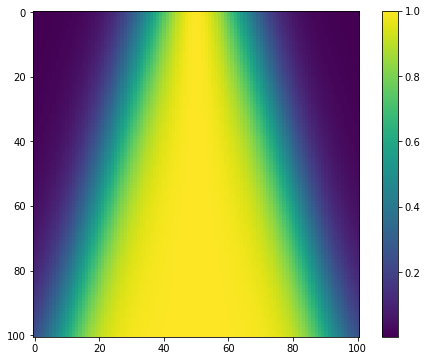

In [13]:
# Visualize PINNsformer
res_test = make_time_sequence(res_test, num_step=5, step=1e-4) 
res_test = torch.tensor(res_test, dtype=torch.float32, requires_grad=True).to(device)
x_test, t_test = res_test[:,:,0:1], res_test[:,:,1:2]

with torch.no_grad():
    pred = model(x_test, t_test)[:,0:1]
    pred = pred.cpu().detach().numpy()

pred = pred.reshape(101,101)

def h(x):
    return np.exp( - (x-np.pi)**2 / (2 * (np.pi/4)**2))

def u_ana(x,t):
    return h(x) * np.exp(5*t) / ( h(x) * np.exp(5*t) + 1 - h(x))

res_test, _, _, _, _ = get_data([0,2*np.pi], [0,1], 101, 101)
u = u_ana(res_test[:,0], res_test[:,1]).reshape(101,101)

rl1 = np.sum(np.abs(u-pred)) / np.sum(np.abs(u))
rl2 = np.sqrt(np.sum((u-pred)**2) / np.sum(u**2))

print('relative L1 error: {:4f}'.format(rl1))
print('relative L2 error: {:4f}'.format(rl2))

plt.figure(figsize=(8,6))
plt.imshow(pred)
plt.colorbar()
plt.show()

## Plot Losses and Step-sizes

In [14]:
# have plots rendered as PDF
# set_matplotlib_formats('pdf')

Text(0.5, 1.0, '1D Reaction / SketchySGD')

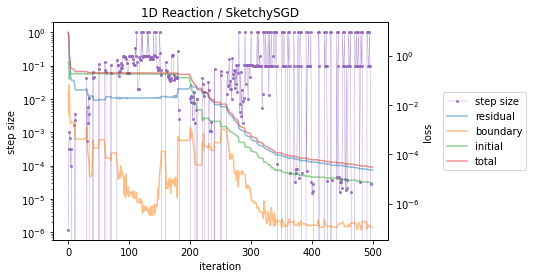

In [15]:
fig = plt.figure()

ax1 = fig.add_subplot()
step_line = ax1.semilogy([float(i) for i in step_size_hist], label='step size', color='C4', alpha=0.85, marker='o', markersize=2, linestyle='solid', linewidth=0.35)
ax1.set_ylabel('step size')
ax1.set_xlabel('iteration')

ax2 = plt.twinx()
loss_line_1 = ax2.semilogy([i[0].cpu() for i in loss_hist], label='residual', alpha=0.5)
loss_line_2 = ax2.semilogy([i[1].cpu() for i in loss_hist], label='boundary', alpha=0.5)
loss_line_3 = ax2.semilogy([i[2].cpu() for i in loss_hist], label='initial', alpha=0.5)
total_loss_line = ax2.semilogy(total_loss_hist, label='total', alpha=0.5)
ax2.set_ylabel('loss')

lines = step_line + loss_line_1 + loss_line_2 + loss_line_3 + total_loss_line
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='center left', bbox_to_anchor=(1.15, 0.5))
optimizer_name = "SketchySGD" if isinstance(optim, SketchySGD) else "L-BFGS"
ax1.set_title(f'1D Reaction / {optimizer_name}')

## Obtain Spectral Information

In [16]:
# define objective/loss function
def criterion(x, t, outputs):
    
    x_res, x_left, x_right, x_upper, x_lower = x
    t_res, t_left, t_right, t_upper, t_lower = t
    outputs_res, outputs_left, outputs_right, outputs_upper, outputs_lower = outputs
    
    u_x = torch.autograd.grad(outputs_res, x_res, grad_outputs=torch.ones_like(outputs_res), retain_graph=True, create_graph=True)[0]
    u_t = torch.autograd.grad(outputs_res, t_res, grad_outputs=torch.ones_like(outputs_res), retain_graph=True, create_graph=True)[0]

    loss_res = torch.mean((u_t - 5 * outputs_res * (1-outputs_res)) ** 2)
    loss_bc = torch.mean((outputs_upper - outputs_lower) ** 2)
    loss_ic = torch.mean((outputs_left[:,0] - torch.exp(- (x_left[:,0] - torch.pi)**2 / (2*(torch.pi/4)**2))) ** 2)
    
    loss = loss_res + loss_bc + loss_ic
    
    return loss_res

In [17]:
# assemble data
x = (x_res, x_left, x_right, x_upper, x_lower)
t = (t_res, t_left, t_right, t_upper, t_lower)
data = (x, t)

In [18]:
# compute hessian information
torch.cuda.empty_cache()
hessian_comp = hessian(model, criterion, data, cuda=True, device=device)

In [19]:
# plot empirical spectral density
density_eigen, density_weight = hessian_comp.density()

In [20]:
# function that generates densities and bins
def generate_density_bins(eigenvalues, weights, num_bins=10000, gaussian_variance=1e-5, zero_eps=1e-7, use_log_scale=True):
    
    # parameters
    margin_percentage = 1/100
    
    # project to real plane
    eigenvalues = np.real(eigenvalues)
    weights = np.real(weights)
    
    # get eigenvalue statistics
    num_runs = eigenvalues.shape[0]
    max_eig = np.mean(np.max(eigenvalues, axis=1), axis=0)
    min_eig = np.mean(np.min(eigenvalues, axis=1), axis=0)

    # compute bins
    neg_bins = []
    pos_bins = []
    if min_eig > 0: 
        lower = min_eig * (1 - margin_percentage)
        upper = max_eig * (1 + margin_percentage)
        if use_log_scale: 
            pos_bins = np.linspace(np.log10(lower), np.log10(upper), num=num_bins)
        else: 
            pos_bins = np.linspace(lower, upper, num=num_bins)
        
    elif max_eig < 0: 
        lower = min_eig * (1 + margin_percentage)
        upper = max_eig * (1 - margin_percentage)
        if use_log_scale: 
            neg_bins = np.linspace(np.log10(-lower), np.log10(-upper), num=num_bins)
        else: 
            neg_bins = np.linspace(lower, upper, num=num_bins)
    else: 
        lower = min_eig * (1 + margin_percentage)
        upper = max_eig * (1 + margin_percentage)
        
        num_neg_bins = max(2, int(-lower / (-lower + upper) * (num_bins - 1))) # here we have 1 additional points at 0
        num_pos_bins = max(2, (num_bins - 1) - num_neg_bins)
        num_bins = num_neg_bins + num_pos_bins + 1
        
        if use_log_scale:  
            neg_bins = np.linspace(np.log10(-lower), np.log10(zero_eps), num=num_neg_bins)
            pos_bins = np.linspace(np.log10(zero_eps), np.log10(upper), num=num_pos_bins)
        else: 
            neg_bins = np.linspace(lower, -zero_eps, num=num_neg_bins)
            pos_bins = np.linspace(zero_eps, upper, num=num_pos_bins)
    
    # helper function to compute Gaussian density
    def gaussian(x, x0, sigma_squared):
        return np.exp(-(x0 - x)**2 / (2.0 * sigma_squared)) / np.sqrt(2 * np.pi * sigma_squared)
    
    # estimate densities
    variance = gaussian_variance * max(1, (upper - lower))
    density = np.zeros((num_runs, num_bins))
    for i in range(num_runs):
        for j in range(len(neg_bins)):
            if use_log_scale: 
                point = -1 * (10 ** neg_bins[j])
            else: 
                point = neg_bins[j]
            approximate_density = gaussian(eigenvalues[i, :], point, variance)
            density[i, j] = np.sum(approximate_density * weights[i, :])
        
        density_idx_offset = len(neg_bins)
        if (min_eig < 0) and (max_eig > 0): 
            approximate_density = gaussian(eigenvalues[i, :], 0, variance)
            density[i, density_idx_offset] = np.sum(approximate_density * weights[i, :])
            density_idx_offset += 1
        
        for j in range(len(pos_bins)):
            if use_log_scale: 
                point = 10 ** pos_bins[j]
            else: 
                point = pos_bins[j]
            approximate_density = gaussian(eigenvalues[i, :], point, variance)
            density[i, density_idx_offset + j] = np.sum(approximate_density * weights[i, :])
    
    # assemble bins
    if (min_eig < 0) and (max_eig > 0): 
        if use_log_scale: 
            bins = np.concatenate([-1 * np.power(10, neg_bins), [0], np.power(10, pos_bins)])
        else: 
            bins = np.concatenate([neg_bins, [0], pos_bins])
    elif len(neg_bins) > 0: 
        if use_log_scale: 
            bins = -1 * np.power(10, neg_bins)
        else:
            bins = neg_bins
    else: 
        if use_log_scale: 
            bins = np.power(10, pos_bins)
        else:
            bins = pos_bins
    
    # normalize
    density = np.mean(density, axis=0) # average runs
    density += zero_eps # add epsilon
    bin_avg_density = 0.5 * (density[:-1] + density[1:])
    bin_length = np.diff(bins, axis=0)
    total_density = np.sum(bin_length * bin_avg_density)
    density = density / total_density
    
    return density, bins

In [21]:
# original plotting implementation from PyHessian tutorial
# code: https://github.com/amirgholami/PyHessian/blob/master/density_plot.py
def density_generate(eigenvalues,
                     weights,
                     num_bins=10000,
                     sigma_squared=1e-5,
                     overhead=0.01):
    
    def gaussian(x, x0, sigma_squared):
        return np.exp(-(x0 - x)**2 / (2.0 * sigma_squared)) / np.sqrt(2 * np.pi * sigma_squared)

    eigenvalues = np.array(eigenvalues)
    weights = np.array(weights)

    lambda_max = np.mean(np.max(eigenvalues, axis=1), axis=0) + overhead
    lambda_min = np.mean(np.min(eigenvalues, axis=1), axis=0) - overhead

    grids = np.linspace(lambda_min, lambda_max, num=num_bins)
    sigma = sigma_squared * max(1, (lambda_max - lambda_min))

    num_runs = eigenvalues.shape[0]
    density_output = np.zeros((num_runs, num_bins))

    for i in range(num_runs):
        for j in range(num_bins):
            x = grids[j]
            tmp_result = gaussian(eigenvalues[i, :], x, sigma)
            density_output[i, j] = np.sum(tmp_result * weights[i, :])
    density = np.mean(density_output, axis=0)
    normalization = np.sum(density) * (grids[1] - grids[0])
    density = density / normalization
    return density + 1e-7, grids

In [34]:
# make plot
# density, bins = density_generate(density_eigen, density_weight)
density, bins = generate_density_bins(density_eigen, density_weight, use_log_scale=True)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9,3))
optimizer_name = "SketchySGD" if isinstance(optim, SketchySGD) else "L-BFGS"
fig.suptitle(f'1D Reaction / {optimizer_name}')

ax1.plot(bins, density)
ax1.set_xscale('symlog')
ax1.set_ylabel('density')
ax1.set_xlabel('eigenvlaue\n(symmetric log scale)')

ax2.semilogy(bins, density)
ax2.set_xscale('symlog')
ax2.set_ylabel('density\n(log scale)')
ax2.set_xlabel('eigenvlaue\n(symmetric log scale)')

plt.tight_layout()
plt.show()

<Figure size 648x216 with 2 Axes>